In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import math

## Load Dataset

In [2]:
df = pd.read_csv("../DataSets/bitcoin_prices5.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df_chart = df.copy()
df_chart

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,price
0,2023-04-13 12:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30216.29
1,2023-04-13 12:28:00,30216.29,NaN,NaN,NaN,NaN,NaN,NaN,30213.57
2,2023-04-13 12:29:00,30213.57,NaN,NaN,NaN,NaN,NaN,NaN,30214.46
3,2023-04-13 12:30:00,30214.46,NaN,NaN,NaN,NaN,NaN,NaN,30256.32
4,2023-04-13 12:31:00,30256.32,NaN,NaN,NaN,NaN,NaN,NaN,30237.66
...,...,...,...,...,...,...,...,...,...
1996,2023-04-14 21:43:00,30512.85,30513.616485,30486.927322,30452.803016,30518.259932,30503.266014,30486.248963,30516.24
1997,2023-04-14 21:44:00,30516.24,30513.265558,30487.896629,30453.970156,30516.484949,30503.873244,30487.225866,30511.16
1998,2023-04-14 21:45:00,30511.16,30512.064764,30488.575164,30454.987953,30513.578712,30503.949148,30487.917401,30504.86
1999,2023-04-14 21:46:00,30504.86,30510.682655,30489.127758,30455.935994,30510.781534,30503.829213,30488.484954,30502.39


## Dataset Summary

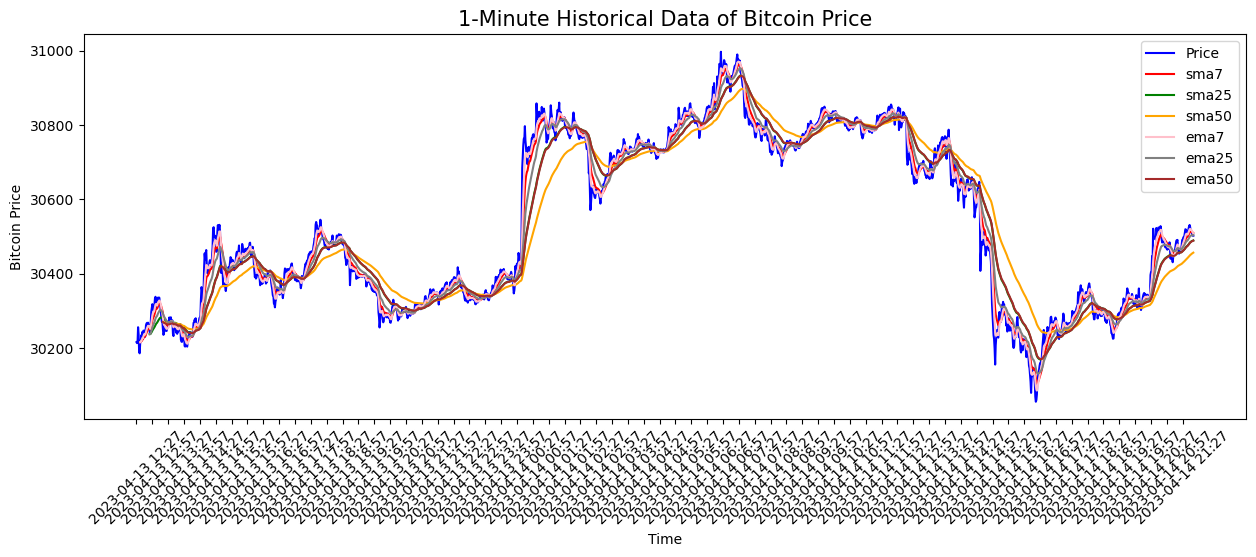

In [3]:
df_chart['timestamp'] = pd.to_datetime(df_chart['timestamp'])
df_chart.set_index('timestamp', inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df_chart.index, df_chart['price'], color='blue', label='Price')
plt.plot(df_chart.index, df_chart['sma7'], color='red', label='sma7')
plt.plot(df_chart.index, df_chart['sma25'], color='green', label='sma25')
plt.plot(df_chart.index, df_chart['sma50'], color='orange', label='sma50')
plt.plot(df_chart.index, df_chart['ema7'], color='pink', label='ema7')
plt.plot(df_chart.index, df_chart['ema25'], color='gray', label='ema25')
plt.plot(df_chart.index, df_chart['ema50'], color='brown', label='ema50')
plt.title('1-Minute Historical Data of Bitcoin Price', fontsize=15)
plt.ylabel('Bitcoin Price')
plt.xlabel('Time')
plt.legend()

tick_values = pd.date_range(start=df_chart.index[0], end=df_chart.index[-1], freq='30T')
tick_labels = [date.strftime('%Y-%m-%d %H:%M') for date in tick_values]
plt.xticks(tick_values, tick_labels, rotation=45)

plt.show()

In [4]:
#drop NAN rows
df = df.drop(df.index[:50])

feature_df = df.iloc[:,1:9]

In [5]:
feature_df

,-1min,sma7,sma25,sma50,ema7,ema25,ema50,price
50,30271.42,30293.747671,30280.362618,30270.983772,30282.120339,30293.132637,30270.592129,30251.01
51,30251.01,30285.473718,30278.581314,30270.280697,30270.547754,30288.724741,30269.228909,30235.83
52,30235.83,30278.997473,30277.043661,30269.677883,30262.945815,30284.987454,30268.088167,30240.14
53,30240.14,30276.200691,30276.338715,30269.472725,30262.064362,30283.020726,30267.748239,30259.42
54,30259.42,30272.376306,30275.262366,30269.071870,30258.905771,30280.436824,30267.029877,30249.43
...,...,...,...,...,...,...,...,...
1996,30512.85,30513.616485,30486.927322,30452.803016,30518.259932,30503.266014,30486.248963,30516.24
1997,30516.24,30513.265558,30487.896629,30453.970156,30516.484949,30503.873244,30487.225866,30511.16
1998,30511.16,30512.064764,30488.575164,30454.987953,30513.578712,30503.949148,30487.917401,30504.86
1999,30504.86,30510.682655,30489.127758,30455.935994,30510.781534,30503.829213,30488.484954,30502.39


In [8]:
features = df.iloc[:,1:8]
features.shape

(1951, 7)

In [9]:
price = df.iloc[:, -1]
price.shape

(1951,)

In [12]:
#Scale Features and Price seperately
x_scaler = StandardScaler()
s_features = x_scaler.fit_transform(features.values)

In [16]:
y_scaler = StandardScaler()
s_price = y_scaler.fit_transform(np.array(price).reshape(-1,1))

In [29]:
def lstm_split(data_x, data_y, n_steps):
    x, y = [], []
    for i in range(len(data_x) - n_steps + 1):
        x.append (data_x[i:i + n_steps])
        y.append(data_y[i + n_steps - 1])
    return np.array(x), np.array(y)

In [30]:
s_features

array([[-1.19956256, -1.10505043, -1.17945385, ..., -1.15521344,
        -1.11202356, -1.22339329],
       [-1.29090795, -1.14234248, -1.18764017, ..., -1.20720926,
        -1.13201741, -1.22965737],
       [-1.35884637, -1.17153196, -1.19470674, ..., -1.24136491,
        -1.14896944, -1.23489916],
       ...,
       [-0.12660101, -0.12105991, -0.22257407, ..., -0.1152669 ,
        -0.15577709, -0.22476939],
       [-0.1547968 , -0.1272893 , -0.22003452, ..., -0.12783467,
        -0.15632111, -0.22216145],
       [-0.16585134, -0.13262233, -0.21759472, ..., -0.13724926,
        -0.15681978, -0.21965397]])

In [31]:
print(s_features[0:3])

[[-1.19956256 -1.10505043 -1.17945385 -1.24853867 -1.15521344 -1.11202356
  -1.22339329]
 [-1.29090795 -1.14234248 -1.18764017 -1.25186469 -1.20720926 -1.13201741
  -1.22965737]
 [-1.35884637 -1.17153196 -1.19470674 -1.25471641 -1.24136491 -1.14896944
  -1.23489916]]


In [32]:
price

50      30251.01
51      30235.83
52      30240.14
53      30259.42
54      30249.43
          ...   
1996    30516.24
1997    30511.16
1998    30504.86
1999    30502.39
2000    30502.40
Name: price, Length: 1951, dtype: float64

In [33]:
print(price[0:2])

50    30251.01
51    30235.83
Name: price, dtype: float64


In [42]:
x1, y1 = lstm_split(s_features, s_price, n_steps=50)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=False)

In [44]:
print(x_train.shape, y_train.shape)

(1331, 50, 7) (1331, 1)


## LSTM Model

In [45]:
model = Sequential ()
model. add(LSTM(units = 100, return_sequences= True, input_shape = (x_train.shape[1], x_train.shape[2])))
model. add (Dropout (0.3))
model. add (LSTM(units = 50, return_sequences= True))
model. add (Dropout (0.3))
model. add(LSTM(units = 100, return_sequences= True))
model. add(Dropout (0.3))
model.add(LSTM(units = 50))
model.add(Dropout (0.2))
model.add(Dense (units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           43200     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            30200     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           60400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                3

## Train

In [47]:
model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
42/42 [==============================] - 9s 90ms/step - loss: 0.1373 - accuracy: 0.0000e+00
Epoch 2/50
42/42 [==============================] - 4s 95ms/step - loss: 0.0605 - accuracy: 0.0000e+00
Epoch 3/50
42/42 [==============================] - 4s 96ms/step - loss: 0.0495 - accuracy: 0.0000e+00
Epoch 4/50
42/42 [==============================] - 4s 99ms/step - loss: 0.0473 - accuracy: 0.0000e+00
Epoch 5/50
42/42 [==============================] - 4s 97ms/step - loss: 0.0473 - accuracy: 0.0000e+00
Epoch 6/50
42/42 [==============================] - 4s 96ms/step - loss: 0.0425 - accuracy: 0.0000e+00
Epoch 7/50
42/42 [==============================] - 4s 98ms/step - loss: 0.0436 - accuracy: 0.0000e+00
Epoch 8/50
42/42 [==============================] - 4s 98ms/step - loss: 0.0374 - accuracy: 0.0000e+00
Epoch 9/50
42/42 [==============================] - 4s 102ms/step - loss: 0.0344 - accuracy: 0.0000e+00
Epoch 10/50
42/42 [==============================] - 4s 100ms/step - los

In [ ]:
# model.save('model_006_v2.h5')
# loaded_model = keras.models.load_model('model_006_v2.h5')

## Evaluate

In [50]:
y_pred = model.predict(x_test)

18/18 [==============================] - 2s 23ms/step


In [64]:
y_pred_usd = y_scaler.inverse_transform(y_pred)
y_pred_usd.shape

(571, 1)

In [61]:
y_test_usd = y_scaler.inverse_transform(y_test)
y_test_usd.shape

(571, 1)

In [72]:
y_pred_diff = y_pred_usd - y_test_usd

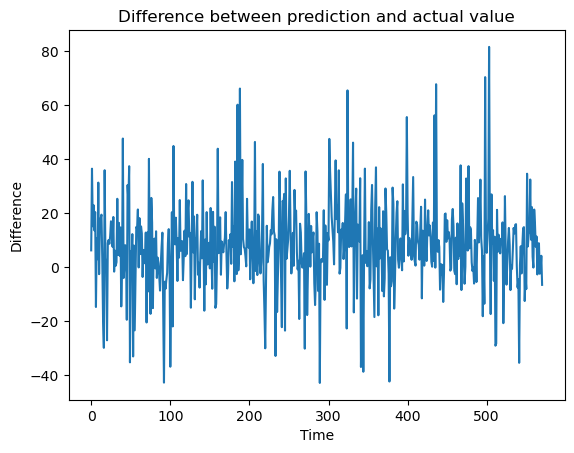

In [77]:
plt.plot(y_pred_diff)
plt.title('Difference between prediction and actual value')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.show()

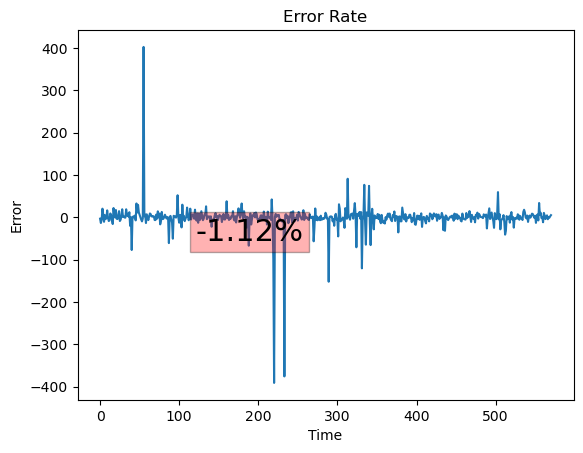

In [58]:

error_rates = (y_test.reshape(-1, 1) - y_pred) / y_test.reshape(-1, 1) * 100
average_error_rate = np.sum(error_rates)/len(error_rates)
plt.plot(error_rates)
plt.text(120,-55, f'{average_error_rate:.2f}%', fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.3))
plt.title('Error Rate')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

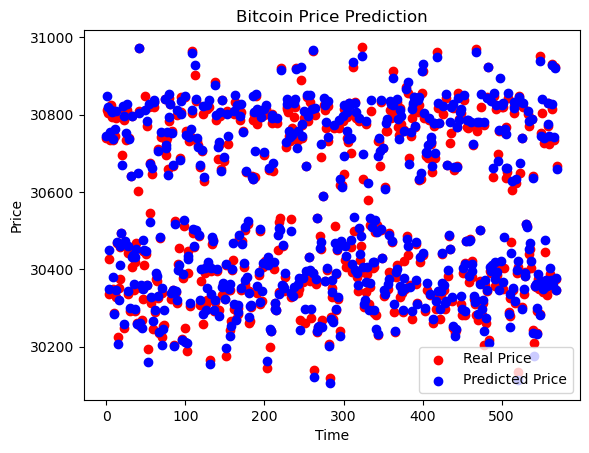

In [71]:
y_test_index = range(len(y_test))

y_test_series = pd.Series(y_test_usd.reshape(-1,), index=y_test_index)
y_pred_series = pd.Series(y_pred_usd.reshape(-1,), index=y_test_index)

plt.scatter(y_test_series.index, y_test_series, color='red', label='Real Price')
plt.scatter(y_pred_series.index, y_pred_series, color='blue', label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()